This provides a framework to construct deep neural networks used to efficiently approximating various functions.
* **modular design**: builds on simple network operations and can be easily adapted and extended
* **versatile usage**: convenient mathematical notation and compatible with usual TensorFlow 2.0 modules


#### Imports

In [0]:
from __future__ import (absolute_import, division, 
                        print_function, unicode_literals)
%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import SVG, display

from tensorflow.keras import layers
from tensorflow import nn
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [198]:
!rm -r oberwolfach_workshop
!git clone https://github.com/juliusberner/oberwolfach_workshop.git

rm: cannot remove 'oberwolfach_workshop': No such file or directory
Cloning into 'oberwolfach_workshop'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.


#### Parametrizations
* theory: https://arxiv.org/abs/1709.05289

In [0]:
# Parametrization class
class P:

  def __init__(self, name_or_parameters, name='parametrization', eps=1e-6):
    if isinstance(name_or_parameters, str):
      name = name_or_parameters
      name_or_parameters = SimpleParametrizations[name_or_parameters]
    self.eps = eps
    self.name = name
    self.parameters = name_or_parameters
    self.weights = [W for W, _ in self.parameters]
    self.biases = [B for _, B in self.parameters]
    self.in_dim = self.weights[0].shape[0]
    self.arch=[self.in_dim]+[len(B) for B in self.biases]
    self.out_dim = self.arch[-1]
    self.width=max(self.arch)
    self.depth=len(self.arch)-1
    self.pa_max=max([max(np.max(W),np.max(B)) for W, B in self.parameters])
    self.num_parameters=sum([self.arch[i]*self.arch[i+1]+self.arch[i+1] 
                             for i in range(self.depth)])
    self.connectivity=sum([(np.abs(W)>eps).sum()+(np.abs(B)>eps).sum() 
                            for W, B in self.parameters])

  def __repr__(self):
    return str(self.parameters)
  
  def __str__(self):
    return str(self.parameters)

  def attributes_print(self):
    print('Depth: {}, Width: {}, Max: {}, #Parameters: {}, Connectivity: {}'.format(
        self.depth,self.width,self.pa_max, self.num_parameters,self.connectivity))

# Parametrizations of simple functions
SimpleParametrizations = {'abs': [(np.array([[1.,-1]]), np.array([0.,0.])), 
                                  (np.array([[1.],[1.]]), np.array([0.]))],
                          'triangle': [(np.array([[1.,1.,1.]]), 
                                  np.array([0.,-0.5,-1.])), 
                                 (np.array([[2.],[-4.],[2.]]), 
                                  np.array([0.]))]}

#### Realization
* tf: https://www.tensorflow.org/guide/keras/custom_layers_and_models
* theory: https://arxiv.org/abs/1709.05289

In [0]:
# affine linear layer
# in order to stay compatible with TensorFlow we multiply the input from left
# e.g. Affine(W,B)(x)=xW+B
class Affine(layers.Layer):

  def __init__(self, W, B):
    super(Affine, self).__init__()
    self.w = tf.Variable(initial_value=tf.constant(W,dtype='float32'),
                         trainable=True)
    self.b = tf.Variable(initial_value=tf.constant(B,dtype='float32'),
                         trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

# realization map
class R(tf.keras.Model):

  def __init__(self, name_or_P, act=nn.relu):
    if isinstance(name_or_P, str):
      name_or_P=P(name_or_P)
    super(R, self).__init__(name=name_or_P.name)
    self.parametrization = name_or_P
    self.act = act
    self.affine_maps = [Affine(W, B) 
                        for W, B in self.parametrization.parameters]

  def call(self, input_tensor, training=False):

    x = input_tensor
    for affine in self.affine_maps[:-1]:
      x = affine(x)
      x = self.act(x)
    return self.affine_maps[-1](x)


#### Derivative map 
* tf: https://www.tensorflow.org/tutorials/customization/autodiff
* theory: https://arxiv.org/abs/1905.04992

In [0]:
# derivative map 
# dR(Pa)(x)/dx via automatic differentiation
def D(Pa):
  def der(x):
    with tf.GradientTape() as t:
      x = tf.convert_to_tensor(x)
      t.watch(x)
      y = R(Pa)(x)
      return t.gradient(y, x)
  return der

#### Helper functions

In [0]:
# blockdiagonal matrix
def blockdiag(matrix_list):
  if len(matrix_list)==2:
    m1 = matrix_list[0]
    m2 = matrix_list[1]
    return np.block([[m1,np.zeros((m1.shape[0],m2.shape[1]))],
                     [np.zeros((m2.shape[0],m1.shape[1])),m2]])
  else:
    return blockdiag([blockdiag(matrix_list[:-1]),matrix_list[-1]])

# print 1-dimensional functions
def print_1d(*functions, interval=[-1,1], sharey=True, figsize=(10,5), num=500):
  shape = np.atleast_2d(functions[0]).shape
  fig, axs = plt.subplots(shape[0], shape[1], sharey=sharey, figsize=figsize)
  x_ev=np.linspace(interval[0],interval[1],num=num, 
                    dtype=np.float32)[:,np.newaxis]
  for function_list in functions:
    function_list = np.array(function_list).flat
    for ax, f in np.nditer([axs,function_list], flags=['refs_ok']):
      print(type(ax))
      print(f)
      ax.item().plot(x_ev,f.item()(x_ev),linewidth=2)
  plt.show()

<class 'numpy.ndarray'>


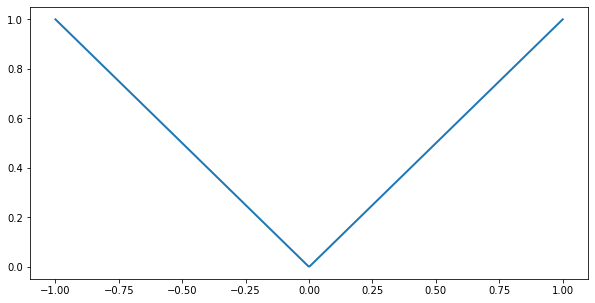

In [585]:
print_1d(R(Square(1.)), interval=[-1,1])

In [505]:
a=np.array([[lambda x: x**2,lambda x: x**2],[lambda x: x**2,lambda x: x**2]])
a=np.array(lambda x: x**2)
np.atleast_2d(lambda x: x**2).shape

(1, 1)

In [564]:
a=[[1,2],[2,3],[5,6]]
b=10
for f,g in np.nditer([a,b]):
  print(f)

1
2
2
3
5
6


In [0]:
def test(*gh):
  print(gh[0])

In [540]:
test('test','kk')

test


In [542]:
for a, b in zip([1,2],*[2,3])

SyntaxError: ignored

#### NN operations and constructions
* theory: https://arxiv.org/abs/1709.05289, https://arxiv.org/abs/1809.07669, https://arxiv.org/abs/1902.07896

In [0]:
# linear network
def Lin(W):
  zeros = np.zeros((W.shape[1],))
  return P([(W,zeros)])

# network concatenation
# e.g. Pa_list = [Pa1, Pa2, Pa3]
# R(Conc(Pa_list))(x)=R(Pa3)(R(Pa2)(R(Pa1)(x)))
def Conc(Pa_list):
  if len(Pa_list)==1: #catch exceptional cases in other functions
    return Pa_list[0]
  if len(Pa_list)==2:
    Pa1=Pa_list[0]
    Pa2=Pa_list[1]
    W=np.matmul(Pa1.weights[-1],Pa2.weights[0])
    B=np.matmul(Pa1.biases[-1],Pa2.weights[0])+Pa2.biases[0]
    return P(Pa1.parameters[:-1]+[(W,B)]+Pa2.parameters[1:])
  else:
    return Conc([Conc(Pa_list[:-1]),Pa_list[-1]])

# positive elongation (with factor) helper function
def _pos_elong(Pa, L, factor = 1):
  Pa_pos = Identity(Pa.out_dim, 1, scale = factor)
  return P(Pa.parameters+[Pa_pos.parameters[0] for _ in range(L-Pa.depth)])

# (affine) linear combination
# e.g. Pa_list = [P1,P2], coeff_list = [A,B]
# then: R(Affine(Pa_list, coeff_list))(x)=A*R(P1)(x)+B*R(P2)(x))
# see parallelization for explanation of ind_list
def Affine_Comb(coeff_list, Pa_list = None, ind_list = None, affine = None):
  block = np.block([coeff_list]).transpose()
  if affine == None:
    Pa_comb = Lin(block)
  else:
    Pa_comb = P([(block,affine)])
  if Pa_list == None:
    return Pa_comb
  else: 
    return Conc([Par(Pa_list, ind_list=ind_list),Pa_comb])

# identity network with possible efficient scaling
# e.g. dim=2, L=4, scale = np.array([16,81]) 
# then R(Identity(dim, L, scale))(x)=(16x_1,81x_2)
# efficient: coefficients with magnitude |scale_i|**(1/L)
def Identity(dim, L, scale = 1):
  id = np.eye(dim)
  if L==1:
    return Lin(scale*id)
  elif L>1:
    factor = np.abs(scale)**(1/L)
    Pa_list = [_pos_elong(Lin(m), L, factor=factor) 
              for m in [factor*id, -factor*id]]
    ind = np.arange(dim)
    return Affine_Comb([np.sign(scale)*id, -np.sign(scale)*id], Pa_list=Pa_list, ind_list=[ind, ind])
  else:
    raise ValueError('L must be a natural number greater than 0.')

# update SimpleParametrizations
SimpleParametrizations.update({'identity': Identity(1,1).parameters})

# parallelization helper function for same depth
def _par_same(Pa_list):
  if len(Pa_list)==2:
    return P([(blockdiag([W1,W2]),np.block([B1,B2])) 
            for (W1, B1), (W2, B2) 
            in zip(Pa_list[0].parameters,Pa_list[1].parameters)])
  else:
    return _par_same([_par_same(Pa_list[:-1]),Pa_list[-1]])

# parallelization with indexed input
# e.g. Pa_list = [P1,P2], ind_list = [(2,0),(1,3)]
# then: R(Par(Pa_list, ind_list))(x_0,x_1,x_2,x_3)=(R(P1)(x_2,x_0),R(P2)(x_1,x_3))
def Par(Pa_list, ind_list = None, in_dim = None):
  L = max([Pa.depth for Pa in Pa_list])
  Pa = _par_same([Elongation(Pa, L) for Pa in Pa_list])
  if ind_list == None:
    return Pa
  else:
    if in_dim == None:
      in_dim = max([max(ind) for ind in ind_list])+1
    perms = [np.zeros((in_dim, Pa.in_dim)) for Pa in Pa_list]
    for perm, ind in zip(perms, ind_list):
      perm[ind,np.arange(len(ind))] = 1
    Pa_perms = Lin(np.block([perms]))
    return Conc([Pa_perms,Pa])

# sparse network concatenation
def Sparse_Conc(Pa_list):
  if len(Pa_list)==2:
    Id = Identity(Pa_list[0].out_dim, 2)
    return Conc([Pa_list[0],Id,Pa_list[1]])
  else:
    return Sparse_Conc([Sparse_Conc(Pa_list[:-1]),Pa_list[-1]])

# network elongation
def Elongation(Pa, L): 
  if Pa.depth == L:
    return Pa
  else:
    return Conc([Pa,Identity(Pa.out_dim,L-Pa.depth+1)])

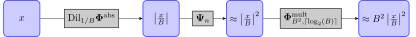

In [260]:
# squaring helper function (interpolates the squaring function up to precision 4**(-k))
def _square(k):
  if k==1:
    return P('identity')
  elif k>1:
    Pa_triang = P('triangle')
    Pa_inp = _pos_elong(P('identity'), 2)
    Pa_sub_list = [_pos_elong(Affine_Comb([-2.**(-2*m),1]), 2) for m in range(1,k-1)]
    Pa_first = Par([Pa_triang, Pa_inp], ind_list=[[0],[0]])
    Pa_middle_list = [Par([Pa_triang, Pa_sub], ind_list=[[0],[0,1]]) 
                      for Pa_sub in Pa_sub_list]
    return Conc([Pa_first]+Pa_middle_list+[Affine_Comb([-2.**(-2*(k-1)),1])])
  else:
    raise ValueError('k must be a natural number greater than 0.')

# approximation of squaring function on [-B,B] 
# up to error eps in Sobolev W^{1,\infty} norm
def Square(eps, B = 1.):
  k = int(np.ceil(2*np.log2(B/eps)+1))
  L = int(np.ceil(np.log2(B))) if B>1 else 1
  return Conc([Lin(np.array([[1/B]])),P('abs'),
                _square(k),Identity(1, L, scale=B**2)])

SVG('oberwolfach_workshop/figures/square.svg')

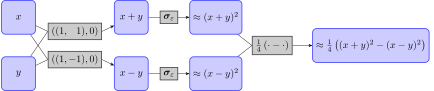

In [261]:
# approximation of multiplication function on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Mult(eps, B = 1.):
  Pa_list = [Conc([Affine_Comb([1., a]), Square(2*eps, B = 2*B)]) 
            for a in [1.,-1.]]
  return Affine_Comb([0.25,-0.25], Pa_list=Pa_list, ind_list=[[0,1],[0,1]])

SVG('oberwolfach_workshop/figures/mult.svg')

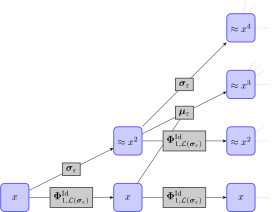

In [322]:
# approximation of monomials function (x,x^2,...,x^(2^2)) on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Monomial(K, eps, B = 1.):
  Pa_list_all=[]
  Pa_id = P('identity')
  eta = eps/(4.**(K**2)*B**(2**(K+1)))
  eta_list = [4**(k**2)*eta for k in range(1,K+1)]  
  E = 2*B**(2**K)
  for k in range(K):
    Pa_list=[]
    ind_list=[]
    Pa_square = Square(eta_list[k], B = E)
    Pa_mult = Mult(eta_list[k], B = E)
    for i in range(2**(k+1)):
      if i<=2**k-1:
        Pa_list.append(Pa_id)
        ind_list.append([i])
      elif i%2:
        Pa_list.append(Pa_square)
        ind_list.append([(i-1)//2])
      else:
        Pa_list.append(Pa_mult)
        ind_list.append([(i-2)//2,i//2])
    Pa_list_all.append(Par(Pa_list, ind_list=ind_list))
  return Conc(Pa_list_all)

SVG('oberwolfach_workshop/figures/monomials.svg')

In [0]:
# approximation of polynomial p[0]*x^(N-1)+ ... +p[N-1] on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Poly(p, eps, B = 1.):
  deg = len(p)-1
  coeff_sum = np.sum(np.abs(p[:-1]))
  eta = eps/coeff_sum
  K = int(np.ceil(np.log2(deg)))
  L = int(np.ceil(np.log2(coeff_sum)))
  Pa_zero = Lin(np.eye(2**K,deg))
  Pa_scale = Identity(deg, L, scale=p[-2::-1])
  #return Monomial(K, eta, B), Pa_zero, Pa_scale, Affine_Comb(np.ones((deg,1)), affine=np.array([p[-1]]))
  return Conc([Monomial(K, eta, B), Pa_zero, Pa_scale, 
               Affine_Comb(np.ones((1,deg)), affine=np.array([p[-1]]))])


In [235]:
# exploring the squaring function approximation networks
interact(lambda eps, B: Square(eps, B = B).attributes_print(), 
         eps=(0.01,0.1,0.01), B=(1.,100.));

interactive(children=(FloatSlider(value=0.05, description='eps', max=0.1, min=0.01, step=0.01), FloatSlider(va…

In [457]:
# visualization of squaring function approximation
square = np.poly1d([1,0,0])
interact(lambda eps: print_1d([R(Square(eps)),square], 
                              [-1,1]), eps=(0.1,1.));
interact(lambda eps: print_1d([D(Square(eps)),np.polyder(square)], 
                              [-1,1]), eps=(0.1,1.));                             

interactive(children=(FloatSlider(value=0.55, description='eps', max=1.0, min=0.1), Output()), _dom_classes=('…

interactive(children=(FloatSlider(value=0.55, description='eps', max=1.0, min=0.1), Output()), _dom_classes=('…

In [455]:
np.polyder(square)

array([2, 0])

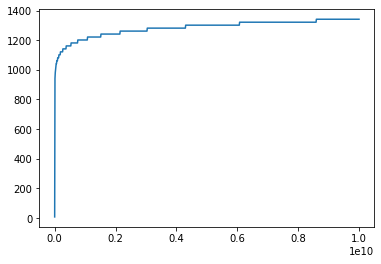

In [114]:
# emprical test of parameter scaling
x = np.linspace(1, 1e10, num=1000)
y = [Square(1/eps).num_parameters for eps in x]
plt.semilogx(x,y,linewidth=2)

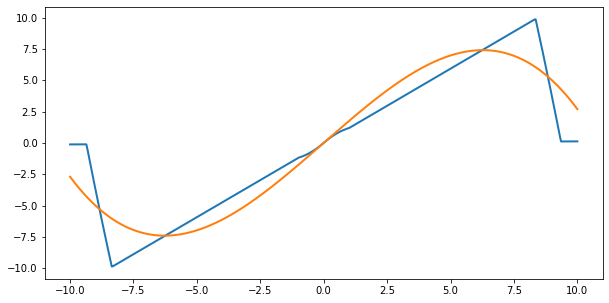

In [430]:
p=[-0.015,0.,1.77,0.]
#a = Poly(p, eps=1e-3)
#a, b, c, d = Poly(p, eps=1e-3)
print_1d([R(Poly(p, eps=200000000000., B=10.)), np.poly1d(p)], interval=[-10,10])

In [436]:
Poly(p, eps=0.001, B=10.).attributes_print()

Depth: 252, Width: 16, Max: 3.7606030930863934, #Parameters: 35119, Connectivity: 6142


In [410]:
test

[(array([[1.],
       [1.],
       [1.]]), array([0.]))]

In [403]:
test

[(array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]), array([0., 0., 0.]))]

In [0]:
t = np.ones((2,1,1))

In [388]:
for a in t:
  print(a)

[[1.]]
[[1.]]


In [411]:
R(test)([[1.,2.,3.]])

<tf.Tensor: id=38741, shape=(1, 1), dtype=float32, numpy=array([[6.]], dtype=float32)>

In [373]:
b.attributes_print()

Depth: 1, Width: 4, Max: 1.0, #Parameters: 15, Connectivity: 3


In [375]:
c.attributes_print()

Depth: 3, Width: 6, Max: 1.4422495703074083, #Parameters: 87, Connectivity: 18


In [376]:
d.attributes_print()

Depth: 1, Width: 3, Max: 5.0, #Parameters: 4, Connectivity: 4


In [395]:
R(d)([[1.,3.,5.]])

InvalidArgumentError: ignored

In [396]:
d

[(array([[[1., 1., 1.]]]), array([5.]))]

#### Testing

In [310]:
np.eye(5,4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [331]:
np.array([p[2]]).shape

(1,)

In [289]:
p[:-1]

[1, 2]

In [277]:
Pa = _monomial(3, eps=0.1, B=2.)

k recursion 0
i recursion 0
i recursion 1
[[0], [0]]
k recursion 1
i recursion 0
i recursion 1
i recursion 2
i recursion 3
[[0], [1], [0, 1], [1]]
k recursion 2
i recursion 0
i recursion 1
i recursion 2
i recursion 3
i recursion 4
i recursion 5
i recursion 6
i recursion 7
[[0], [1], [2], [3], [1, 2], [2], [2, 3], [3]]


In [279]:
R(Pa)([[3.]])

<tf.Tensor: id=31154, shape=(1, 8), dtype=float32, numpy=
array([[3.000e+00, 9.000e+00, 2.700e+01, 8.100e+01, 2.430e+02, 7.290e+02,
        2.187e+03, 6.561e+03]], dtype=float32)>

In [182]:
R(Pa)([[8.,8.]])

<tf.Tensor: id=18807, shape=(1, 1), dtype=float32, numpy=array([[63.99999]], dtype=float32)>

In [0]:
Pa = Lin(np.eye(2))

In [0]:
Pos = Lin(np.eye(Pa.out_dim))

In [15]:
[Pos.parameters for _ in range(3)]

[[(array([[1., 0.],
          [0., 1.]]), array([0., 0.]))], [(array([[1., 0.],
          [0., 1.]]), array([0., 0.]))], [(array([[1., 0.],
          [0., 1.]]), array([0., 0.]))]]

In [13]:
Pa.parameters

[(array([[1., 0.],
         [0., 1.]]), array([0., 0.]))]

In [157]:
P('triangle')

[(array([[1., 1., 1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

In [159]:
Identity(1,1)

[(array([[1.]]), array([0.]))]

In [160]:
_par_same([P('triangle'),Identity(1,1)])

[(array([[1., 1., 1., 0.],
       [0., 0., 0., 1.]]), array([ 0. , -0.5, -1. ,  0. ]))]

In [0]:
y = np.zeros((4,3))
ind = [0,3,1]

In [0]:
y[ind,np.arange(len(ind))] = 1

In [172]:
y

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.]])

In [0]:
a = Lin

In [0]:
I =Identity(2,4)

In [63]:
I.attributes_print()

Depth: 4, Width: 4, #Parameters: 62, Connectivity: 16


In [68]:
_par([I,I,I]).attributes_print()

Depth: 4, Width: 12, #Parameters: 426, Connectivity: 48


In [36]:
blockdiag([np.ones((3,4)),np.ones((3,4)),np.ones((2,1)),np.ones((3,1))])

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [252]:
np.block([np.zeros((3,)),np.zeros((3,))])

array([0., 0., 0., 0., 0., 0.])

In [0]:
IdNet = P('identity')

In [0]:
theta = P('abs')

In [0]:
theta.arch

[1, 2, 1]

In [0]:
theta.attributes_print()

Depth: 2, Width: 2, #Parameters: 7, Connectivity: 4


In [0]:
theta.name

'abs'

In [0]:
theta

[(array([[ 1., -1.]]), array([0., 0.])), (array([[1.],
       [1.]]), array([0.]))]

In [0]:
AbsNet=R(theta)
TriangleNet=R(P('triangle'))

In [0]:
TriangleNet.parametrization

[(array([[1., 1., 1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

In [0]:
AbsNet.layers[0].get_weights()

[array([[ 1., -1.]], dtype=float32), array([0., 0.], dtype=float32)]

In [0]:
AbsNet.name

'abs'

In [0]:
x = tf.constant([[-2.],[-1.],[1.]])

In [0]:
abs(x) #.numpy()

<tf.Tensor: id=914, shape=(3, 1), dtype=float32, numpy=
array([[2.],
       [1.],
       [1.]], dtype=float32)>

In [0]:
R('identity').parametrization.weights

[array([[ 1., -1.]]), array([[ 1.],
        [-1.]])]

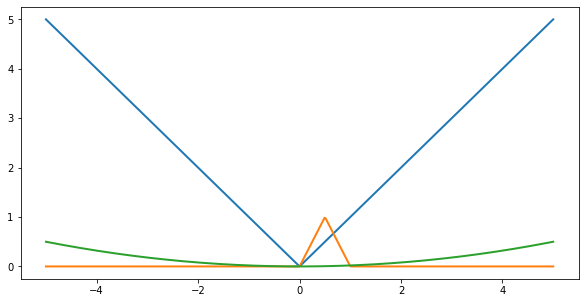

In [0]:
print_1d([AbsNet,TriangleNet,lambda x: 0.02*x**2],[-5,5])

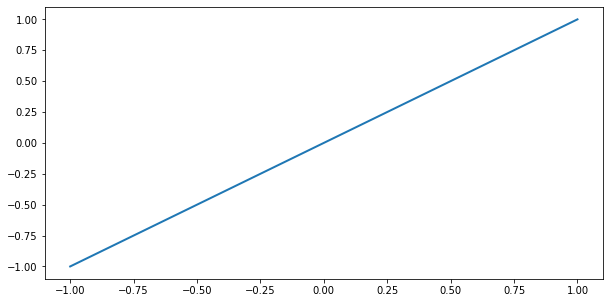

In [0]:
print_1d(R('identity'))

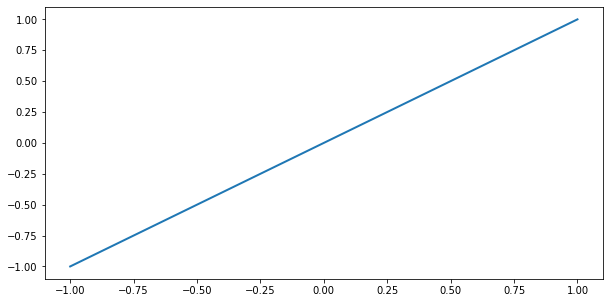

In [0]:
print_1d(R(long_Id))

In [0]:
phi = P('triangle')

In [0]:
phi_4 = Sparse_Conc([phi for _ in range(4)])

In [0]:
phi_4el = Elongation(phi_4,9)

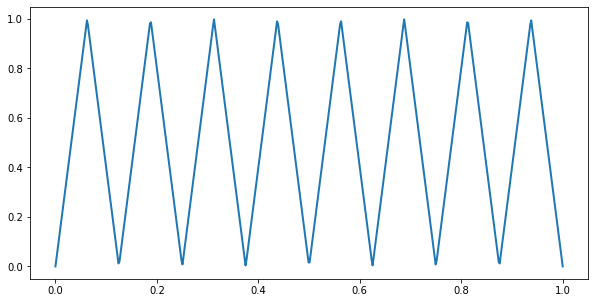

In [276]:
print_1d(R(phi_4el),[0,1])

In [28]:
phi_4el.attributes_print()
phi_4.attributes_print()

Depth: 9, Width: 3, #Parameters: 68, Connectivity: 55
Depth: 8, Width: 3, #Parameters: 61, Connectivity: 50


In [24]:
phi_4el

[(array([[1., 1., 1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.,  1.,  1.],
       [-1., -1., -1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.,  1.,  1.],
       [-1., -1., -1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.,  1.,  1.],
       [-1., -1., -1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.],
       [-1.]]), array([0.]))]

In [26]:
phi_4

[(array([[1., 1., 1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.,  1.,  1.],
       [-1., -1., -1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.,  1.,  1.],
       [-1., -1., -1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2., -2.],
       [-4.,  4.],
       [ 2., -2.]]), array([0., 0.])), (array([[ 1.,  1.,  1.],
       [-1., -1., -1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

# Importing and Helper Functions

In [0]:
import torch
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
class math_net: 
    name='mathematical neural net'
    eps=1e-6
    def __init__(self,weights,biases):
        self.weights=weights
        self.biases=biases
        self.tuples=[(w,b) for w,b in zip(self.weights,self.biases)]
        self.arch=[w.size()[1] for w in self.weights]+[self.weights[-1].size()[0]]
        self.width=max(self.arch)
        self.depth=len(self.weights)
        self.parameters=sum([self.arch[i]*self.arch[i+1]+self.arch[i+1] for i in range(self.depth)])
        self.connectivity=sum([(torch.abs(w)>self.eps).sum()+(torch.abs(b)>self.eps).sum() for w,b in zip(self.weights,self.biases)])

    def __repr__(self):
         return str(self.tuples)
    def __str__(self):
         return str(self.tuples)

    def attributes_print(self):
        print('Depth: {}, Width: {}, Parameters: {}, Connectivity: {}'.format(self.depth,self.width,self.parameters,self.connectivity))
    
    def realization(self,inp,act=F.relu,grad=False): #get the realization of the network nn at inp (nn derivative if grad=True)
        inp=torch.tensor(inp,dtype=torch.float32)
        out=inp
        inp.requires_grad_(grad)
        for w,b in zip(self.weights[:-1],self.biases[:-1]):
            out=act(torch.matmul(w,out)+b)
        out=torch.matmul(self.weights[-1],out)+self.biases[-1]
        if grad:
            out.backward(torch.ones(inp.size()))
            grad=inp.grad
            return out.detach().numpy(), grad.numpy()
        else: 
            return out.numpy()  

    def print_1d(self,I,dist=1e-3,act=F.relu,grad=False,function=None,derivative=None): #print the realization of the network in the interval I (including the derivative)
        fig=plt.figure(figsize=(16,8))
        x_ev=np.linspace(I[0],I[1],num=500)
        y_ev=self.realization(x_ev[:,None,None],act=act,grad=False)
        if grad:  
            eps=10**(-2)
            xx=np.arange(I[0],I[1]+self.eps,dist,dtype=np.float32)
            [yy,grad_points]=self.realization(xx[:,None,None],act=act,grad=True)
            ax1=plt.subplot(121)
            ax2=plt.subplot(122)
            eps=10**(-5)
            delta=.01
            xx_low=xx-eps
            xx_up=xx+eps
            [_,grad_points_low]=self.realization(xx_low[:,None,None],act=act,grad=True)
            [_,grad_points_up]=self.realization(xx_up[:,None,None],act=act,grad=True)
            circles=list()
            grads=list()
            x_grads=list()
            x_circles=list()
            for i,x in enumerate(xx):
                for j, grad_uplow in enumerate([grad_points_low,grad_points_up]):
                    grad=grad_uplow[i,0,0]
                    grads.append(grad)
                    x_grads.append(x+(-1)**(j+1)*delta) #draw at delta distance to the circles
                    if abs(grad-grad_points[i,0,0])>eps:
                        circles.append(grad)
                        x_circles.append(x)
                    if j==0 and abs(x)< I[1]+eps: #exclude the holes outside of the interval
                        x_grads.append(x)
                        grads.append(np.nan)  

            ax1.plot(x_ev,y_ev[:,0,0],'b',linewidth=2)
            ax2.scatter(xx[1:-1],grad_points[1:-1,0,0],facecolors='b', edgecolors='b', s=30) #exclude the points outside of the interval
            ax2.plot(x_grads,grads,'b',linewidth=2)
            ax2.scatter(x_circles,circles,facecolors='none', edgecolors='b', s=30)
            if function:
                ax1.plot(x_ev,function(x_ev),'g',linewidth=1)
            if derivative:
                ax2.plot(x_ev,derivative(x_ev),'g',linewidth=1)

        else:
            plt.plot(x_ev,y_ev[:,0,0],'b',linewidth=2)
            if function:
                plt.plot(x_ev,function(x_ev),'g',linewidth=1)
        plt.show()
             

## Network Operations

In [0]:
def net_conc(net1,net2):    
    w=torch.matmul(net2.weights[0],net1.weights[-1])
    b=torch.matmul(net2.weights[0],net1.biases[-1])+net2.biases[0]
    return math_net(net1.weights[:-1]+[w]+net2.weights[1:],net1.biases[:-1]+[b]+net2.biases[1:])
  
def net_conc_ntimes(net,n):
    net_new=net
    for _ in range(n):
        net_new=net_conc(net_new,net)
    return net_new    


## Networks

In [0]:
def abs_net(): #absolute value network
    w=[torch.tensor([[1.],[-1]]),torch.tensor([[1.,1.]])]
    b=[torch.tensor([[0.],[0.]]),torch.tensor([[0.]])]
    return math_net(w,b)

def triangle_net(): #triangle network (Telgarsky)
    w=[torch.tensor([[1.],[1.],[1.]]),torch.tensor([[2.,-4.,2.]])]
    b=[torch.tensor([[0.],[-0.5],[-1.]]),torch.tensor([[0.]])]
    return math_net(w,b)

def square_net(m): #squaring function 
  if m==1:
      w=[torch.tensor([[1.]])]
      b=[torch.tensor([[0.]])]
  else:    
      w=[torch.tensor([[2.,-4.,2.,0.],[2.,-4.,2.,0.],[2.,-4.,2.,0.],[-2.**(-2*i+3),2.**(-2*i+4),-2.**(-2*i+3),1.]]) for i in range(2,m)]
      b=[torch.tensor([[0.],[-0.5],[-1.],[0.]]) for i in range(2,m)]
      w=[torch.tensor([[1.],[1.],[1.],[1.]])]+w+[torch.tensor([[-2.**(-2*m+3),2.**(-2*m+4),-2.**(-2*m+3),1.]])]
      b=[torch.tensor([[0.],[-0.5],[-1.],[0.]])]+b+[torch.tensor([[0.]])]
  return math_net(w,b)


#General Definition of ReLU Networks and its Realizations 

(due to [P. Petersen and F. Voigtländer](https://arxiv.org/abs/1709.05289))

1. Define a ReLU network $\Phi$ to be a finite sequence of matrix-vector pairs, i.e.
    $$\Phi=((A_k,b_k))_{k=1}^L$$ 
   where  $A_k\in\mathbb{R}^{N_k\times N_{k-1}}$ and $b_k\in\mathbb{R}^{N_k}$.
    
    
2. Define its realization $\mathcal{R}\Phi\colon \mathbb{R}^{N_0}\to\mathbb{R}^{N_L}$ by $$\mathcal{R}\Phi := W_L\circ ReLU\circ\,W_{L-1}\circ\ldots\circ ReLU\circ\,W_1$$ with $W_k(x)=A_k x + b_k$.

# Telgarsky Saw-Tooth Construction 

Matus Telgarsky: [Benefits of depth in neural networks](https://arxiv.org/abs/1602.04485)

*"For any positive integer k, there exist neural networks with $\mathcal{O}(k^3)$  layers, $\mathcal{O}(1)$ nodes per layer, and $\mathcal{O}(1)$ distinct parameters which can not be approximated by networks with $\mathcal{O}(k)$ layers unless they are exponentially large --- they must possess $\Omega(2^k)$ nodes."*

Each application of the triangle ReLU network doubles the number of "theeth"  $\Rightarrow$  $2^k$ teeth with $\mathcal{O(k)}$ network size (layers/parameters)

[(tensor([[1.],
        [1.],
        [1.]]), tensor([[ 0.0000],
        [-0.5000],
        [-1.0000]])), (tensor([[ 2., -4.,  2.]]), tensor([[0.]]))]
Depth: 2, Width: 3, Parameters: 10, Connectivity: 8


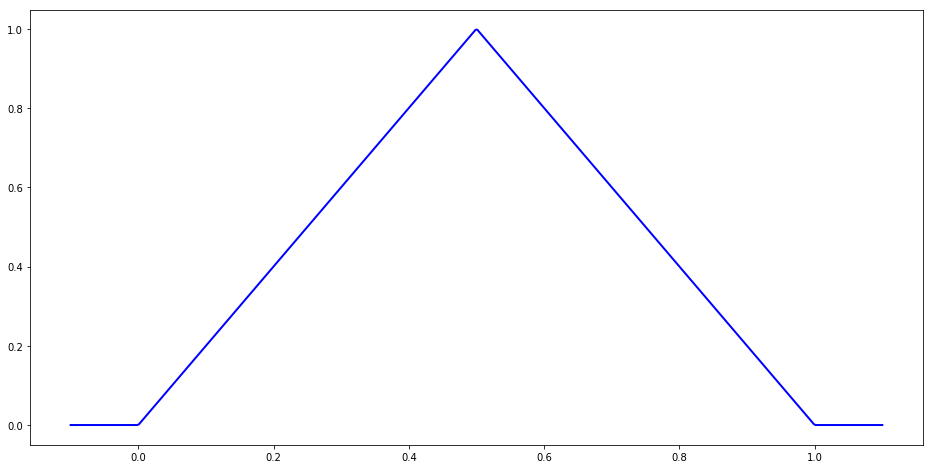

In [0]:
#@title Number of Applications of the Triangle Function: { run: "auto" }
n = 0 #@param {type:"slider", min:0, max:4, step:1}
net=net_conc_ntimes(triangle_net(),n)
if n==0:
    print(net)
net.attributes_print()
net.print_1d([-0.1,1.1])

# Yarotsky Squaring Network 

Dmitry Yarotsky:[ Error bounds for approximations with deep ReLU networks](https://arxiv.org/abs/1610.01145)

*"Proposition 2. The function $f (x) = x^2$ on the segment [0, 1] can be approximated with any
error $\varepsilon > 0$ by a ReLU network having the depth and the number of weights and computation
units $\mathcal{O}(ln(1/\varepsilon))$."*

* $\Big($ linear interpolations of $f$ on intervals of size $2^{-k}$ $\Big)$ - $\Big($ linear interpolation on intervals of size $2^{-(k+1)}$  $\Big)$ = $\Big($ scaled saw-thooth function with $2^k$ "theeth" $\Big)$

* "on the fly" add the scaled sawthooth functions in an additional node $\Rightarrow$ precision $\mathcal{O}(2^{-k})$ with ReLU networks of size $\mathcal{O}(k)$

Depth: 3, Width: 4, Parameters: 33, Connectivity: 25


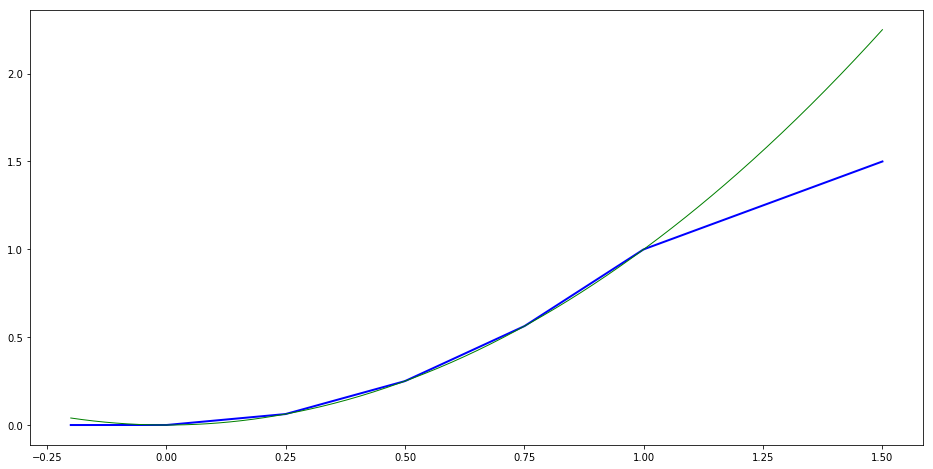

In [0]:
#@title Number of Layers / Size of Interval: { run: "auto" }
n = 1 #@param {type:"slider", min:1, max:5, step:1}
a = -0.2 #@param {type:"number"}
b = 1.5 #@param {type:"number"}
net=square_net(n)
net.attributes_print()
net.print_1d([a,b],function=lambda x: x**2)

# Approximation in $W^{1,\infty}$ norm

Reminder: 

$$ W^{n,p}(\Omega):= \{g\in L^p(\Omega): D^\alpha g \in L^p(\Omega)  \quad \forall\alpha\in\mathbb{N}_0^d \quad \text{with} \quad |\alpha|\le n\}$$

$D^\alpha g$ is the $\alpha$-th weak derivatives of $g$, if $$\int_{\Omega} g (D^{\alpha} \phi) = (-1)^{|\alpha|} \int_{\Omega} (D^{\alpha} g) \phi$$ for all $\phi\in C^\infty_c(\Omega)$.

---



$$\|g\|_{W^{n,\infty}(\Omega)}:=\max_{0\le|\alpha|\le n} \|D^{\alpha} g\|_{L^\infty(\Omega)}$$


---

Therefore: 

$\Big($ ReLU network $\Phi$ approximates $f$ in the $W^{1,\infty}$ norm $\Big)$ $\Leftrightarrow$ $\Big($ $\mathcal{R}(\Phi)$ and its weak gradient uniformly approximate f and the weak gradient of f , respectively $\Big)$

Observe that all ReLU networks are continuous piecewise linear and thus Lipschitz continuous and a.e. classically differentiable (due to Rademacher's theorem) with its weak derivative a.e. coinciding with its classical derivative.


Ingo Gühring, Gitta Kutyniok, Philipp Petersen: [Error bounds for approximations with deep ReLU neural networks in $W^{s,p}$ norms](https://arxiv.org/abs/1902.07896)

Joost Opschoor, Philipp Petersen, Christoph Schwab: [Deep ReLU Networks and High-Order Finite Element Methods](https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf)

*"...the same construction can be used when measuring the
approximation error in the $W^{1,\infty}$ norm. In particular, the depth and the number of weights and neurons
of the network do not grow asymptotically faster to satisfy the approximation accuracy with respect to
this stronger norm."*

Let $f(x)=x^2$. There are ReLU networks $\Phi_\varepsilon$ of size $\mathcal{O(\log(1/\varepsilon))}$ satisfying $\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1))} \le \varepsilon$.

Depth: 5, Width: 4, Parameters: 73, Connectivity: 55


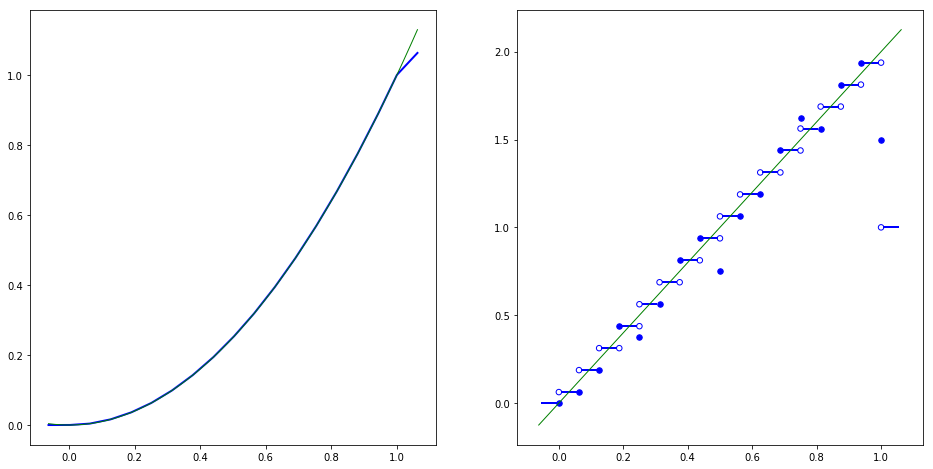

In [0]:
#@title Number of Layers { run: "auto" }
n = 5 #@param {type:"slider", min:1, max:5, step:1}
net=square_net(n)
net.attributes_print()
net.print_1d([-2**(-n+1),1+2**(-n+1)],dist=2**(-n+1),grad=True,function=lambda x: x**2,derivative=lambda x: 2*x)

# Richer Classes of Functions (in the spirit of Yarotsky)

Combing (composition, linear combination) the squaring networks (and exactly representable easy networks) one gets 
* networks approximating multiplication: $xy=\left|\frac{x+y}{2}\right|^2-\left|\frac{x-y}{2}\right|^2$
* polynomials 
* functions whose first $n\geq 1$ (weak) derivatives are bounded: local Taylor approximation



---


**Problem: Classical Chain-Rule fails! **

...although all ReLU networks a.e. differentiable.

Very simple counterexample: 

$u(x):=ReLU(x)$

$v(x):=0$ 

formally apply the chain rule: $$D(u\circ v)(x)=\color{blue}{D u(v(x))}\cdot D v(x)$$

$D u(y)$ is well-defined for all $y\neq 0$, but the expression $\color{blue}{D u(v(x))}$ is not defined for any $x\in\mathbb{R}$.


**Inner function maps a set of positive measure into a set where the derivative of the outer function does not exist.**

---


**What happens in PyTorch / Tensorflow when computing the gradients in the back-propagation (as this is based on the chain-rule)??**

# ReLU Network Derivative

The derivative of the ReLU at zero is set to zero in PyTorch and Tensorflow, i.e.
$\color{blue}{\frac{\partial ReLU}{\partial x}(x) :=1_{(0,\infty)}(x)}$

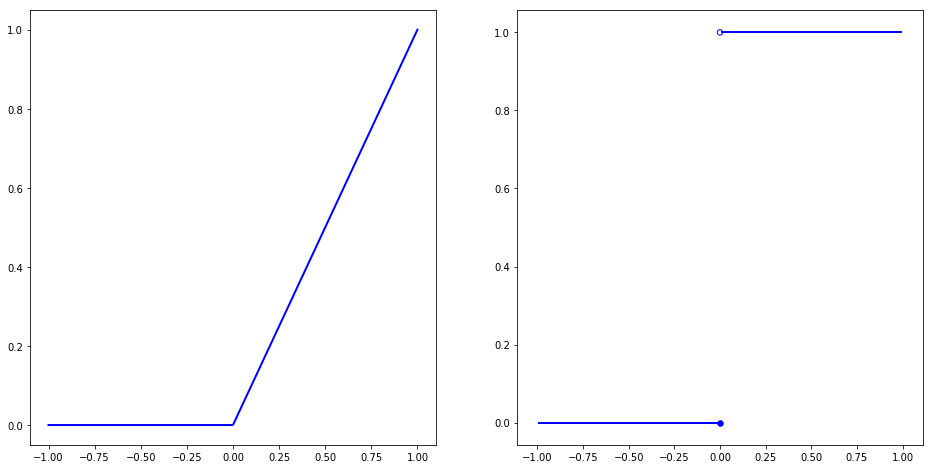

In [0]:
net=math_net([torch.tensor([[1.]]),torch.tensor([[1.]])],[torch.tensor([[0.]]),torch.tensor([[0.]])])
net.print_1d([-1,1],dist=1,grad=True)


Let us define the derivative w.r.t. the inputs in the same fashion: 

We define the derivative of a ReLU network $\Phi=((W_k,b_k))_{k=1}^L$ by $$\mathcal{D}^{\mathcal{N}}\Phi:=A_L\cdot H(\mathcal{R}_{L-1}\Phi)\cdot A_{L-1}\cdot\ldots\cdot H(\mathcal{R}_1\Phi)\cdot A_1$$ with $ \mathcal{R}_K\Phi:=\mathcal{R}((A_k,b_k))_{k=1}^{K} $ and 

$$\color{blue}{H(x):=\text{diag}(\mathbb{1}_{(0,\infty)}(x_1),\dots,\mathbb{1}_{(0,\infty)}(x_N))}.$$


---



Then it holds that the classical derivative of the realization function coincides with the  neural network derivative almost everywhere, i.e. 

$$\color{green}{\mathcal{D}^{\mathcal{N}}\Phi=D\mathcal{R}\Phi \quad a.e.}$$

and the chain rule holds by definition everywhere, i.e. 
 $$\color{green}{\mathcal{D}^{\mathcal{N}}(\Psi\circ\Phi)=\mathcal{D}^{\mathcal{N}}\Psi(\mathcal{R}\Phi)\cdot\mathcal{D}^{\mathcal{N}}\Phi}.$$


with  $\Psi\!=\!((\tilde{A}_k,\tilde{b}_k))_{k=1}^{\tilde{L}}$ and $    \Psi\circ\Phi:=\big(((A_k,b_k))_{k=1}^{L-1},(\tilde{A}_1A_{L},\tilde{A}_1 b_{L}+\tilde{b}_1),((\tilde{A}_k,\tilde{b}_k))_{k=2}^{\tilde{L}}\big)$.



---

On the nullset the derivative can be arbitrary wrong, e.g. take the network $\Phi=\left(\left(\begin{pmatrix} 1 \\ -1 \end{pmatrix},\begin{pmatrix} 0 \\ 0 \end{pmatrix}\right),((a,-b),0)\right)$ then it holds:

1. $\mathcal{R}\Phi(x)=aReLU(x)-bReLU(-x)=\begin{cases}  bx, &x< 0 \\  ax, &x\ge 0 \end{cases}$
2. $ \mathcal{D}^{\mathcal{N}}\Phi(x)=\begin{cases}  b, &x< 0 \\  a, & x> 0 \\ \color{blue}0, & x=0\end{cases}$

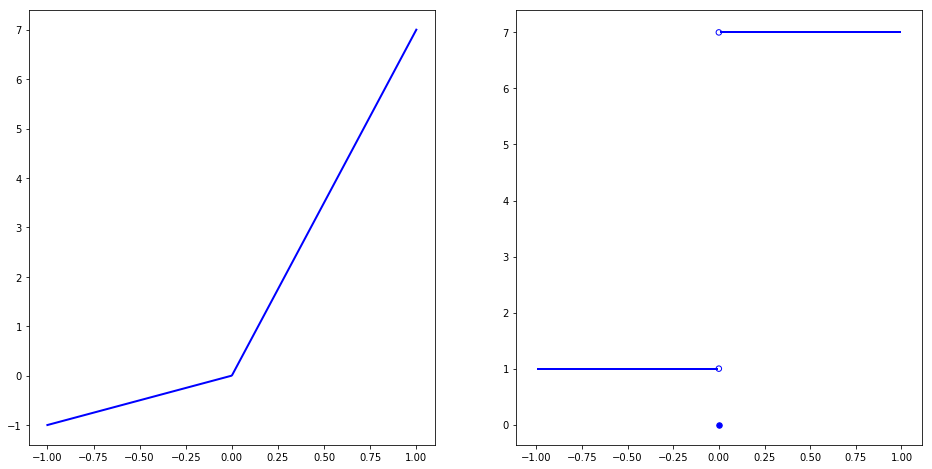

In [0]:
#@title Change Slopes { run: "auto" }
a = 7 #@param {type:"integer"}
b = 1 #@param {type:"integer"}
net=math_net([torch.tensor([[1.],[-1.]]),torch.tensor([[a,-b]],dtype=torch.float32)],[torch.tensor([[0.],[0.]]),torch.tensor([[0.]])])
net.realization(np.array([[-1.]]))
net.print_1d([-1,1],dist=1,grad=True)

For convex $\mathcal{R}\Phi$ the values of $\mathcal{D}^{\mathcal{N}}\Phi$ on the nullset do not necessarily lie in the respective subdifferentials of $\mathcal{R}\Phi$.

Although our results hold regardless of which value is chosen for the derivative of $ReLU$ at the origin, no choice will guarantee that all values of $\mathcal{D}^{\mathcal{N}} \Phi$ lie in the respective subdifferentials of $\mathcal{R}\Phi$.

#Results

### ...for classes of Sobolev-regular functions: Ingo Gühring, Gitta Kutyniok, Philipp Petersen:

There exists $c=c(d,n,B)\ge 0$ such that for any $\varepsilon\ge 0$ and
$$f\in\{g\in W^{n,\infty}((0,1)^d): \|g\|_{W^{n,\infty}((0,1)^d)}\le B\}$$
there exists a ReLU network $\Phi$ with
$$\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1)^d)} \le \varepsilon$$
and
$$Depth(\Phi)\le c \cdot log(\varepsilon^{-n/(n-1)}), \quad Connectivity(\Phi)\le  c \cdot \varepsilon^{-d/(n-1)} \cdot log^2(\varepsilon^{-n/(n-1)}).$$

The result holds also for:

* (fractional) Sobolev spaces $W^{s,p}$ with $0\le s \le 1$ and $1\le p \le \infty$ by a Banach space interpolation argument
* any continuous piecewise linear activation function with $1\le M < \infty$ breakpoints
* lower bound: $Connectivity(\Phi)\ge  c \cdot \varepsilon^{-d/2(n-1)}$


# Global (Pointwise) Error Estimates

For suitable functions $f$ with at most polynomially growing derivative we want ReLU networks $\Phi_\varepsilon$ with:
$$ 
|f(x)-\mathcal{R}{\Phi_\varepsilon}(x)|\le \varepsilon(1+\|x\|^{\kappa}_2) \quad \color{blue}{x\in\mathbb{R}^d}
$$
$$
    \|D f(x) -\mathcal{D}^{\mathcal{N}}\Phi_\varepsilon(x)\|_2 \le C\varepsilon^r(1+\|x\|_2^{\kappa}) \quad \color{blue}{a.e. \ x\in\mathbb{R}^d}
$$

Idea:
1. ReLU networks $\Phi_{\varepsilon,B}$ with $\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((-B,B)^d)} \le \varepsilon$
2.  ReLU network $\Phi_B^{\operatorname{char}}$ which represents the $d$-dimensional approximate characteristic function of $[-B,B]^d$ (see [Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen, Christoph Schwab](https://arxiv.org/abs/1809.07669))
3. ReLU network $\Phi_{\varepsilon,b}^{\operatorname{mult}}$ approximating the multiplication function on $[-b,b]^2$ with error $\varepsilon$
4. Define the global approximation networks $\Phi_\varepsilon$ as the composition of $\Phi_{\varepsilon/2,b_\varepsilon}^{\operatorname{mult}}$ with the parallelization of $\Phi_{B_\varepsilon}^{\operatorname{char}}$ and $\Phi_{\varepsilon/2,B_\varepsilon+1}$ for suitable 
\begin{equation}
    B_\varepsilon\in \mathcal{O}(\varepsilon^{-1}) \quad \text{and} \quad b_\varepsilon\in \mathcal{O}(\varepsilon^{-\nu}).
\end{equation}
